## Prefect API.ipynb

This notebook demonstrates how to orchestrate a real-time Bitcoin ETL pipeline using Prefect 2.x. It includes fetching, validating, storing, visualizing, and monitoring Bitcoin price data with alerting features.

### Imports and Setup

In [43]:
# %%
#! pip install requests
#! pip install pandas
#! pip install matplotlib
#! pip install
#pip install
! pip install prefect pandas matplotlib requests sqlalchemy psycopg2-binary python-dotenv

import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import base64
import io
import smtplib
from email.mime.text import MIMEText
from sqlalchemy import create_engine
from dotenv import load_dotenv

from prefect import flow, task, get_run_logger
from prefect.artifacts import create_markdown_artifact
from datetime import timedelta

load_dotenv()

True

In [44]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


##  Environment Variables and Email Alert Utility

In [45]:
# %%
POSTGRES_URL = os.getenv("POSTGRES_URL")
ALERT_EMAIL = os.getenv("ALERT_EMAIL")
EMAIL_APP_PASSWORD = os.getenv("EMAIL_APP_PASSWORD")


def send_email_alert(subject, body):
    msg = MIMEText(body)
    msg["Subject"] = subject
    msg["From"] = ALERT_EMAIL
    msg["To"] = ALERT_EMAIL

    try:
        server = smtplib.SMTP_SSL("smtp.gmail.com", 465)
        server.login(ALERT_EMAIL, EMAIL_APP_PASSWORD)
        server.sendmail(ALERT_EMAIL, ALERT_EMAIL, msg.as_string())
        server.quit()
        print(" Email alert sent.")
    except Exception as e:
        print(f" Email failed: {e}")

## Task 1: Fetch Bitcoin Price

In [46]:
@task
def fetch_bitcoin_price():
    logger = get_run_logger()
    url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"
    response = requests.get(url)
    data = response.json()

    if response.status_code != 200 or "bitcoin" not in data or "usd" not in data["bitcoin"]:
        logger.error(" Failed to fetch price.")
        return None

    price = data["bitcoin"]["usd"]
    timestamp = response.headers.get("Date")
    logger.info(f" Bitcoin Price: ${price}")
    return {"price": price, "timestamp": timestamp}


## ✅ Task 2: Validate Data

In [47]:
@task
def validate_data(data):
    if not data or "price" not in data or data["price"] <= 0:
        get_run_logger().warning("⚠️ Invalid data.")
        return None
    return data

## Task 3: Log to Prefect Artifacts

In [48]:
@task
def log_to_prefect_artifact(data):
    markdown = f"""
### 📊 Bitcoin Price Log

| Timestamp | Price (USD) |
|-----------|-------------|
| {data['timestamp']} | ${data['price']} |
"""
    create_markdown_artifact(key="bitcoin-price-log", markdown=markdown)

## Task 4: Visualize Price Trend from PostgreSQL

In [49]:
def visualize_price(data):
    logger = get_run_logger()
    try:
        engine = create_engine(POSTGRES_URL)
        df = pd.read_sql("SELECT * FROM prices ORDER BY timestamp DESC LIMIT 20", con=engine)
        df = df.sort_values("timestamp")
    except Exception as e:
        logger.warning(f" Could not read from DB: {e}")
        return

    fig, ax = plt.subplots()
    ax.plot(df["timestamp"], df["price"], marker="o", linestyle="-", color="blue")
    ax.set_title("Bitcoin Price Trend")
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Price (USD)")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True)

    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format="png")
    buf.seek(0)
    encoded = base64.b64encode(buf.read()).decode("utf-8")
    markdown = f"### Bitcoin Price Chart\n\n![chart](data:image/png;base64,{encoded})"
    create_markdown_artifact(key="bitcoin-trend-chart", markdown=markdown)

## 🗄️ Task 5: Save to PostgreSQL

In [50]:
def save_to_postgres(data):
    df = pd.DataFrame([data])
    try:
        engine = create_engine(POSTGRES_URL)
        df.to_sql("prices", con=engine, if_exists="append", index=False)
        get_run_logger().info(" Data saved to PostgreSQL.")
    except Exception as e:
        get_run_logger().error(f" DB Error: {e}")

## 🚨 Task 6: Detect and Alert on Price Spikes

In [51]:
def detect_trend():
    try:
        engine = create_engine(POSTGRES_URL)
        df = pd.read_sql("SELECT * FROM prices ORDER BY timestamp DESC LIMIT 2", con=engine)
    except Exception as e:
        get_run_logger().warning(f"Could not read DB: {e}")
        return

    if len(df) < 2:
        print("ℹ Not enough data to detect trend.")
        return

    latest, previous = df.iloc[0], df.iloc[1]
    change = (latest['price'] - previous['price']) / previous['price']
    msg = f" Bitcoin price changed:\nCurrent: ${latest['price']}\nPrevious: ${previous['price']}\nChange: {change:.2%}"

    if change > 0.05:
        send_email_alert(" Price Spike", msg)
    elif change < -0.05:
        send_email_alert(" Price Drop", msg)
    else:
        print("No major spike/drop.")

## 🔁 Orchestrated Flow

In [52]:
@flow(name="bitcoin-etl-flow")
def bitcoin_etl_flow():
    data = fetch_bitcoin_price()
    data = validate_data(data)
    if data:
        log_to_prefect_artifact(data)
        visualize_price(data)
        save_to_postgres(data)
        detect_trend()

## ⏱️ Scheduled Run Entry

18:29:27.457 | INFO    | Flow run 'nifty-teal' - Beginning flow run 'nifty-teal' for flow 'bitcoin-etl-flow'

18:29:27.459 | INFO    | Flow run 'nifty-teal' - View at http://127.0.0.1:4200/runs/flow-run/c1560103-a127-4734-b832-17e1544c96b9

18:29:27.939 | INFO    | Task run 'fetch_bitcoin_price-232' -  Bitcoin Price: $103054

18:29:27.943 | INFO    | Task run 'fetch_bitcoin_price-232' - Finished in state Completed()

18:29:28.308 | INFO    | Task run 'validate_data-a62' - Finished in state Completed()

18:29:28.720 | INFO    | Task run 'log_to_prefect_artifact-fc1' - Finished in state Completed()

18:29:29.000 | INFO    | Flow run 'nifty-teal' -  Data saved to PostgreSQL.

No major spike/drop.


18:29:29.066 | INFO    | Flow run 'nifty-teal' - Finished in state Completed()

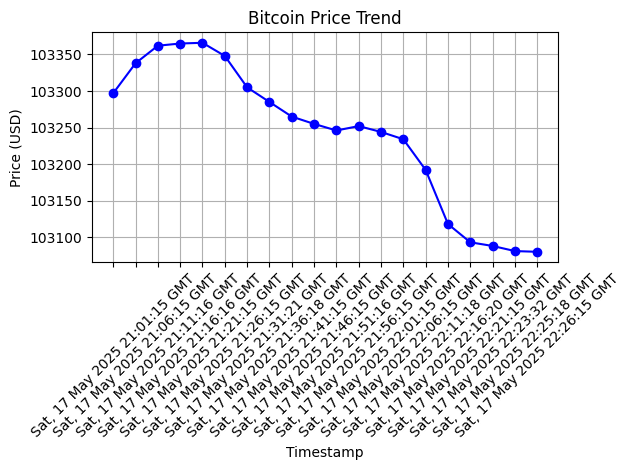

In [53]:
if __name__ == "__main__":
    bitcoin_etl_flow()